In [56]:
import pandas as pd
import altair as alt
from IPython.display import display, Markdown
import missingno as msno

In [57]:
df = pd.read_csv('/Users/kaitlinsinger/wa_notify/DEN_future/data_extraction/manipulated_data/simplified_wide_df_with_date_loc_imputed.csv')

In [58]:
df.head()

,Unnamed: 0,Unnamed: 0.1,source,pm_start_date,pm_end_date,pm_location,cases_assigned_count,cases_interviewed_count,cases_interviewed_from_positive_hdcount,cases_interviewed_from_positive_mean,...,staff_hired_ci_per_hd_mean,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_hd_mean,staff_hired_per_10kpop,test_result_from_collection_mean,user_cases_notifying,users_with_code,region,time_period
0,0,0,A Multifaceted Evaluation of a COVID-19 Contac...,2021-03-01,3/31/21,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T3
1,1,1,A Multifaceted Evaluation of a COVID-19 Contac...,2021-04-01,6/30/20,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T4
2,2,2,A Multifaceted Evaluation of a COVID-19 Contac...,2020-07-01,6/30/21,King County,52317.0,42900.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T2
3,3,3,A Multifaceted Evaluation of a COVID-19 Contac...,2020-07-01,9/30/20,King County,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Northwest,T2
4,4,4,A Patient-Initiated Digital COVID-19 Contact N...,2020-05-18,8/17/20,United States*,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,T2


In [59]:
# data profiling
df.describe()

,Unnamed: 0,Unnamed: 0.1,cases_assigned_count,cases_interviewed_count,cases_interviewed_from_positive_hdcount,cases_interviewed_from_positive_mean,cases_interviewed_from_positive_median,cases_interviewed_perc,cases_interviewed_perc_hdcount,cases_interviewed_perc_mean,...,quarantine_adherent_perc,staff_hired_ci_count,staff_hired_ci_per_hd_mean,staff_hired_count,staff_hired_ct_count,staff_hired_ct_per_hd_mean,staff_hired_per_10kpop,test_result_from_collection_mean,user_cases_notifying,users_with_code
count,83.000000,83.000000,5.700000e+01,4.500000e+01,14.000000,14.000000,14.000000,50.000000,14.000000,14.000000,...,1.0,14.000000,14.000000,1.0,14.00000,14.000000,1.00,1.00,2.000000,2.000000
mean,41.000000,41.000000,8.424556e+05,4.451350e+05,50.357143,38.914286,25.714286,65.375600,52.285714,53.321429,...,81.0,37499.500000,714.428571,962.0,35464.00000,664.285714,4.15,13.68,72521.500000,261789.500000
std,24.103942,24.103942,1.640655e+06,7.101208e+05,1.984833,12.025029,6.414270,20.814334,1.857565,8.460331,...,NaN,10845.303441,202.581689,NaN,12265.24458,229.232978,NaN,NaN,6243.045771,261422.326752
min,0.000000,0.000000,4.000000e+01,4.000000e+01,47.000000,26.400000,24.000000,26.610000,47.000000,32.400000,...,81.0,26288.000000,487.000000,962.0,22292.00000,425.000000,4.15,13.68,68107.000000,76936.000000
25%,20.500000,20.500000,4.987000e+03,3.534000e+03,50.000000,29.400000,24.000000,48.262500,52.250000,50.350000,...,81.0,28847.750000,562.000000,962.0,24107.00000,458.000000,4.15,13.68,70314.250000,169362.750000
50%,41.000000,41.000000,1.410600e+04,1.029000e+04,51.000000,37.200000,24.000000,68.755000,53.000000,53.500000,...,81.0,32354.500000,628.000000,962.0,31645.00000,586.000000,4.15,13.68,72521.500000,261789.500000
75%,61.500000,61.500000,9.410350e+05,7.113790e+05,51.750000,44.400000,24.000000,81.000000,53.000000,60.650000,...,81.0,45323.250000,855.000000,962.0,45371.25000,852.000000,4.15,13.68,74728.750000,354216.250000
max,82.000000,82.000000,6.078802e+06,2.681000e+06,53.000000,64.800000,48.000000,100.000000,54.000000,61.800000,...,81.0,54651.000000,1072.000000,962.0,54905.00000,1077.000000,4.15,13.68,76936.000000,446643.000000


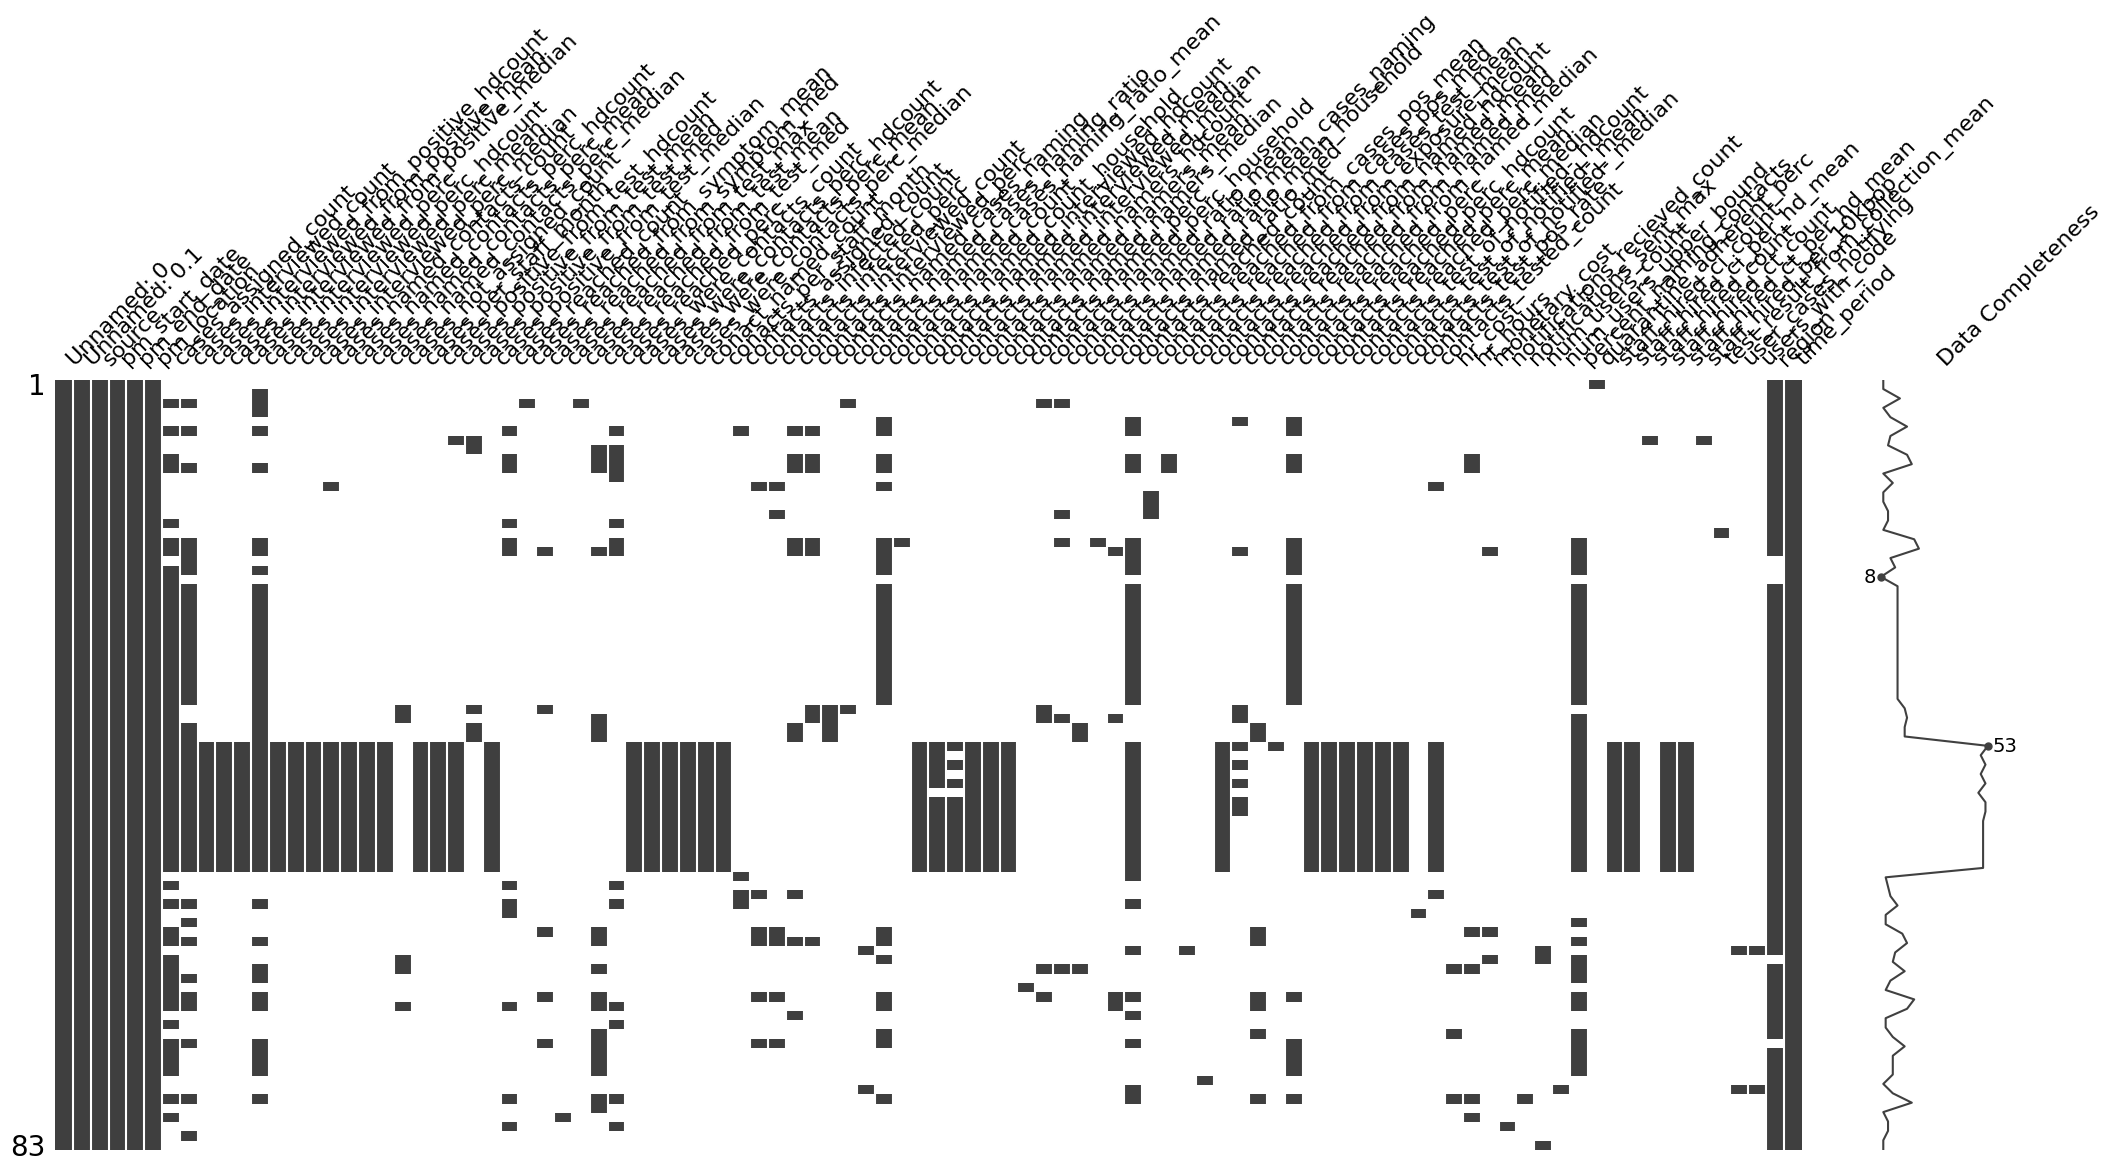

In [60]:
# missingness map
msno.matrix(df, labels=True)
plt.show()

In [67]:
# data analysis

In [66]:
alt.Chart(df).mark_tick().encode(
    alt.X('cases_assigned_count:Q')
)

alt.Chart(...)

In [61]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_assigned_count:Q"),
    alt.Y("source:N")
)

alt.Chart(...)

In [62]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_interviewed_count:Q"),
    alt.Y("source:N")
)

alt.Chart(...)

In [63]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_interviewed_perc:Q"),
    alt.Y("source:N")
)

alt.Chart(...)

In [64]:
alt.Chart(df).mark_point().encode(
    alt.X("cases_interviewed_perc:Q"),
    alt.Y("region:N")
)

alt.Chart(...)

In [80]:
alt.Chart(df).mark_point().encode(
    alt.X("time_period:O"),
    alt.Y("cases_interviewed_perc:Q"),
    alt.Size("cases_assigned_count:Q"),
    #alt.Color("region:N"),
    tooltip = [
        alt.Tooltip("source:N"),
        alt.Tooltip("pm_start_date:T"),
        alt.Tooltip("pm_end_date:T")
   ]
).properties(
    width=500
)

alt.Chart(...)